### In this experiment we used the training2017 dataset to perform a multi class classification using a Single Transformer Encoder Block:
      - MultiHeadAttention
      - Residual + LayerNorm
      - FeedForward
      - Residual + LayerNorm

The results achieved were not satisfactory!!

In [1]:
###########################################
# 0. Imports
###########################################
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import spectrogram

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, LayerNormalization, Dropout,
                                     MultiHeadAttention, GlobalAveragePooling1D,
                                     Add)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.over_sampling import RandomOverSampler


In [15]:
###########################################
# 1. Load and Preprocess ECG Data
###########################################
def load_physionet_2017(data_path="training2017/"):
    """
    Loads the PhysioNet 2017 dataset from a given folder.
    data_path should contain:
      - .mat & .hea files (e.g., A00001.mat, A00001.hea, ...)
      - REFERENCE.csv for labels
    Returns:
      signals_array (list of 1D numpy arrays)
      labels_array  (numpy array of integer class labels)
    """
    # 1) Read the reference file
    reference_file = os.path.join(data_path, "REFERENCE.csv")
    if not os.path.exists(reference_file):
        raise FileNotFoundError("REFERENCE.csv not found in data_path!")

    reference_df = pd.read_csv(reference_file, header=None)
    reference_df.columns = ['record', 'label']

    # 2) Map text labels to numeric
    #    N=Normal, A=AF, O=Other, ~=Noisy
    label_dict = {'N': 0, 'A': 1, 'O': 2, '~': 3}
    reference_df['label_mapped'] = reference_df['label'].map(label_dict)

    # 3) Loop over all .mat files
    mat_files = glob.glob(os.path.join(data_path, "*.mat"))
    signals_list = []
    labels_list = []

    for mat_file in mat_files:
        base = os.path.splitext(os.path.basename(mat_file))[0]  # e.g. A00001
        if base not in reference_df['record'].values:
            continue

        # Load the .mat file
        mat_data = loadmat(mat_file)
        if 'val' not in mat_data:
            continue
        ecg_signal = mat_data['val'][0]

        # Get numeric label
        label = reference_df.loc[reference_df['record'] == base, 'label_mapped'].values[0]

        signals_list.append(ecg_signal)
        labels_list.append(label)

    # Convert to arrays
    signals_array = np.array(signals_list, dtype=object)
    labels_array = np.array(labels_list, dtype=np.int32)

    return signals_array, labels_array


def normalize_signal(signal):
    """Mean-std normalization."""
    mean_val = np.mean(signal)
    std_val = np.std(signal) if np.std(signal) > 1e-6 else 1e-6
    return (signal - mean_val) / std_val

In [16]:
###########################################
# 2. Segment Signals
###########################################
def segment_signals(signals, labels, sample_time_size=5, step_size=None, fs=300):
    """
    Segments ECG signals into windows of length sample_time_size (in seconds).
    If step_size is None, no overlap (step_size=window_size).
    Returns arrays of (num_segments, window_size) and (num_segments,).
    """
    window_size = fs * sample_time_size
    if step_size is None:
        step_size = window_size

    segs, seg_labels = [], []
    for i, sig in enumerate(signals):
        sig_len = len(sig)
        if sig_len < window_size:
            # skip if too short
            continue

        # Slide over the signal in step_size increments
        for start in range(0, sig_len - window_size + 1, step_size):
            segment = sig[start:start+window_size]
            segs.append(segment)
            seg_labels.append(labels[i])

    return np.array(segs, dtype=np.float32), np.array(seg_labels, dtype=np.int32)


In [17]:
###########################################
# 3. Feature Extraction (Spectrogram-based)
###########################################
def compute_instantaneous_frequency_spectrogram(signal, fs=300):
    # Adjust nperseg / noverlap if needed
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=128, noverlap=64)
    Sxx = np.abs(Sxx)
    Sxx_norm = Sxx / np.sum(Sxx, axis=0, keepdims=True)
    inst_freq = np.sum(f[:, np.newaxis] * Sxx_norm, axis=0)
    return inst_freq, t

def compute_spectral_entropy(signal, fs=300):
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=128, noverlap=64)
    Sxx = np.abs(Sxx)
    psd = Sxx / np.sum(Sxx, axis=0, keepdims=True)
    spectral_entropy = -np.sum(psd * np.log(psd + 1e-12), axis=0)
    spectral_entropy /= np.log(psd.shape[0])  # normalize
    return spectral_entropy, t

def extract_features_dataset(signals, fs=300):
    """
    For each 1D signal, compute:
      - Instantaneous frequency (1D)
      - Spectral entropy (1D)
    Returns a list of [2, time_steps] arrays.
    """
    features = []
    for sig in signals:
        inst_freq, _ = compute_instantaneous_frequency_spectrogram(sig, fs)
        spec_entropy, _ = compute_spectral_entropy(sig, fs)

        # Ensure same length
        min_len = min(len(inst_freq), len(spec_entropy))
        inst_freq = inst_freq[:min_len]
        spec_entropy = spec_entropy[:min_len]

        feat_matrix = np.vstack((inst_freq, spec_entropy))  # shape: (2, min_len)
        features.append(feat_matrix)
    return features

In [18]:
###########################################
# 4. Prepare Final Input Tensors
###########################################
def pad_and_prepare(features_list):
    # 1) Find max length
    max_length = max(feat.shape[1] for feat in features_list)
    # 2) Pad each feature matrix to max_length
    padded_list = []
    for feat in features_list:
        pad_width = max_length - feat.shape[1]
        if pad_width > 0:
            feat_padded = np.pad(feat, ((0,0), (0,pad_width)), mode='constant')
        else:
            feat_padded = feat
        padded_list.append(feat_padded)
    # 3) Convert shape from (2, time_steps) -> (time_steps, 2)
    X_final = np.array([f.T for f in padded_list], dtype=np.float32)
    return X_final

In [19]:
###########################################
# 5. Define Transformer Architecture
###########################################
def positional_encoding(sequence_length, d_model):
    """
    Generates positional encoding for transformer input.
    shape: (sequence_length, d_model)
    """
    pos = np.arange(sequence_length)[:, np.newaxis]        # (seq_len, 1)
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

    pos_encoding = np.zeros((sequence_length, d_model))
    pos_encoding[:, 0::2] = np.sin(pos * div_term)
    pos_encoding[:, 1::2] = np.cos(pos * div_term)

    return tf.convert_to_tensor(pos_encoding, dtype=tf.float32)

def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    """
    Single Transformer Encoder Block:
      - MultiHeadAttention
      - Residual + LayerNorm
      - FeedForward
      - Residual + LayerNorm
    """
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    x = Add()([attn_output, inputs])  # Residual
    x = LayerNormalization(epsilon=1e-6)(x)

    ffn = Dense(ff_dim, activation='relu')(x)
    ffn = Dropout(dropout)(ffn)
    # Project back to original dimension
    ffn = Dense(inputs.shape[-1])(ffn)
    x = Add()([ffn, x])  # Residual
    x = LayerNormalization(epsilon=1e-6)(x)

    return x

def build_transformer_model(sequence_length, d_input,
                            d_model=64, head_size=64,
                            num_heads=4, ff_dim=128,
                            num_transformer_blocks=2, dropout=0.1, num_classes=4):
    """
    Build a Transformer-based model for multi-class classification.
    """
    inputs = Input(shape=(sequence_length, d_input))  # e.g. (None, seq_len, 2)
    
    # 1) Map from d_input -> d_model
    x = Dense(d_model)(inputs)

    # 2) Add positional encoding
    pos_encoding = positional_encoding(sequence_length, d_model)
    x = x + pos_encoding

    # 3) Stacked Transformer Encoders
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads,
                                ff_dim=ff_dim, dropout=dropout)

    # 4) Global pooling -> single vector per segment
    x = GlobalAveragePooling1D()(x)

    # 5) Final classification
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Loaded 8528 signals. Label distribution:
  Label 0 count: 5050
  Label 1 count: 738
  Label 2 count: 2456
  Label 3 count: 284
X_segments shape: (54593, 1500)
Y_segments shape: (54593,)
Final feature shape: (54593, 22, 2)
Train: (34939, 22, 2), (34939,)
Valid: (8735, 22, 2), (8735,)
Test:  (10919, 22, 2),  (10919,)
Oversampler results:
  Original train distribution: [20441  2991 10673   834]
  Resampled distribution: [20441 20441 20441 20441]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 22, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 22, 64)    │        192 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 22, 64)    │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 22, 64)    │     66,368 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 22, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 22, 64)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 22, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 22, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 22, 128)   │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 22, 64)    │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 22, 64)    │          0 │ dense_6[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 22, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 22, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 22, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 22, 64)    │          0 │ dropout_4[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 22, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 22, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 22, 128)   │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 22, 64)    │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 22, 64)    │          0 │ dense_8[0][0],    │
│                     │                   │            │ layer_normalizat

 Total params: 175,428 (685.27 KB)

 Trainable params: 175,428 (685.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.3692 - loss: 1.3175 - val_accuracy: 0.2830 - val_loss: 1.4775
Epoch 2/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.4642 - loss: 1.1876 - val_accuracy: 0.4634 - val_loss: 1.1849
Epoch 3/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.4880 - loss: 1.1374 - val_accuracy: 0.4562 - val_loss: 1.1824
Epoch 4/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.4940 - loss: 1.1211 - val_accuracy: 0.4521 - val_loss: 1.1978
Epoch 5/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.4983 - loss: 1.1107 - val_accuracy: 0.4437 - val_loss: 1.2084
Epoch 6/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5016 - loss: 1.1040 - val_accuracy: 0.4319 - val_loss: 1.2215
Epoch 7/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5046 - loss: 1.0998 - val_accuracy: 0.4556 - val_loss: 1.1878
Epoch 8/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5062 -

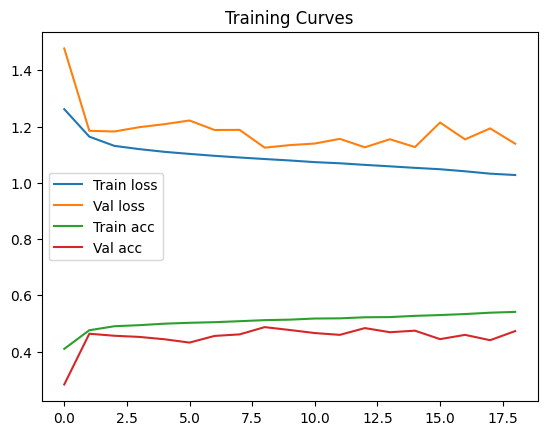


Evaluating on Test set...
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Confusion Matrix:
[[4075 1023  609  681]
 [ 220  498   96  121]
 [1435  855  558  487]
 [  20   29   24  188]]

Classification Report:
              precision    recall  f1-score   support

           0     0.7087    0.6379    0.6714      6388
           1     0.2071    0.5326    0.2982       935
           2     0.4336    0.1673    0.2415      3335
           3     0.1273    0.7203    0.2163       261

    accuracy                         0.4871     10919
   macro avg     0.3692    0.5145    0.3569     10919
weighted avg     0.5678    0.4871    0.4973     10919


Evaluating on Training set...
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
Train Confusion Matrix:
[[13118  3343  1925  2055]
 [  752  1592   268   379]
 [ 4534  2740  1876  1523]
 [   75   115    48   596]]
Train Classification Report:
              precision    recall  f1-score   support

           0     0.7099    0.6417    0.6741     20441
           1     

In [20]:
###########################################
# 6. Main Routine
###########################################
if __name__ == "__main__":
    # 1) Load signals
    signals_array, labels_array = load_physionet_2017("training2017/")
    print(f"Loaded {len(signals_array)} signals. Label distribution:")
    for lbl in np.unique(labels_array):
        print(f"  Label {lbl} count: {(labels_array==lbl).sum()}")

    # 2) Normalize signals
    signals_norm = []
    for sig in signals_array:
        sig = sig.astype(np.float32)
        sig = normalize_signal(sig)
        signals_norm.append(sig)
    signals_norm = np.array(signals_norm, dtype=object)

    # 3) Segment signals (5-second windows @ 300 Hz)
    X_segments, Y_segments = segment_signals(signals_norm, labels_array,
                                             sample_time_size=5, fs=300)
    print("X_segments shape:", X_segments.shape)
    print("Y_segments shape:", Y_segments.shape)

    # 4) Feature extraction
    X_features = extract_features_dataset(X_segments, fs=300)
    X_final = pad_and_prepare(X_features)
    print("Final feature shape:", X_final.shape)

    # 5) Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_final, Y_segments,
        test_size=0.2, random_state=42, stratify=Y_segments
    )
    # Further split off a validation set from training
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train,
        test_size=0.2, random_state=42, stratify=y_train
    )

    print(f"Train: {X_train.shape}, {y_train.shape}")
    print(f"Valid: {X_valid.shape}, {y_valid.shape}")
    print(f"Test:  {X_test.shape},  {y_test.shape}")

    # 6) (Optional) Oversampling if class imbalance is large
    ros = RandomOverSampler(random_state=42)
    n_train = X_train.shape[0]
    seq_len = X_train.shape[1]
    n_feats = X_train.shape[2]

    X_train_2d = X_train.reshape(n_train, -1)
    X_resampled, y_resampled = ros.fit_resample(X_train_2d, y_train)
    X_resampled = X_resampled.reshape(-1, seq_len, n_feats)
    print("Oversampler results:")
    print("  Original train distribution:", np.bincount(y_train))
    print("  Resampled distribution:", np.bincount(y_resampled))

    # 7) Build Transformer
    transformer_model = build_transformer_model(
        sequence_length=seq_len, d_input=n_feats,
        d_model=64, head_size=64, num_heads=4, ff_dim=128,
        num_transformer_blocks=2, dropout=0.1, num_classes=4
    )
    transformer_model.summary()

    # 8) Train
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = transformer_model.fit(
        X_resampled, y_resampled,
        validation_data=(X_valid, y_valid),
        epochs=50,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=1
    )

    # Plot loss & accuracy
    plt.figure()
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Val loss')
    plt.plot(history.history['accuracy'], label='Train acc')
    plt.plot(history.history['val_accuracy'], label='Val acc')
    plt.legend()
    plt.title("Training Curves")
    plt.show()

    # 9) Evaluate
    print("\nEvaluating on Test set...")
    y_pred_test_probs = transformer_model.predict(X_test)
    y_pred_test = np.argmax(y_pred_test_probs, axis=-1)

    cm = confusion_matrix(y_test, y_pred_test)
    print("Confusion Matrix:")
    print(cm)

    report = classification_report(y_test, y_pred_test, digits=4)
    print("\nClassification Report:")
    print(report)

    # Optional: Check performance on training set
    print("\nEvaluating on Training set...")
    y_pred_train_probs = transformer_model.predict(X_train)
    y_pred_train = np.argmax(y_pred_train_probs, axis=-1)
    cm_train = confusion_matrix(y_train, y_pred_train)
    report_train = classification_report(y_train, y_pred_train, digits=4)
    print("Train Confusion Matrix:")
    print(cm_train)
    print("Train Classification Report:")
    print(report_train)
